In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

IMAGE_PATH = os.path.abspath(os.getcwd())
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(os.path.abspath(os.getcwd()), fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tf_agents.environments import suite_gym

env = suite_gym.load("ALE/Breakout-v5")
env

c:\Users\clare\anaconda3\envs\late-tf-env\lib\site-packages\gym\utils\seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
c:\Users\clare\anaconda3\envs\late-tf-env\lib\site-packages\gym\utils\seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(


In [4]:
print(env.get_info())
print(env.action_spec())
print(env.gym.get_action_meanings())

None
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


Saving figure breakout-plot


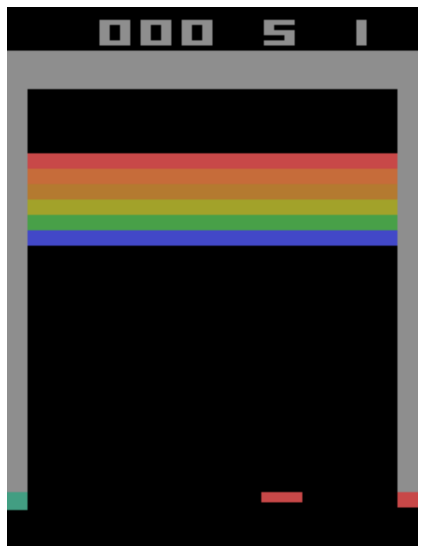

In [5]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("breakout-plot")
plt.show()

In [11]:
from tf_agents.environments.wrappers import ActionRepeat
from gym.wrappers import TimeLimit
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

class AtariPreprocessingWithSkipStart(AtariPreprocessing):
    def skip_frames(self, num_skip):
        for _ in range(num_skip):
          super().step(0) # NOOP for num_skip steps
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        self.skip_frames(40)
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:
            self.skip_frames(40)
        return obs, rewards, done, info


repeating_env = ActionRepeat(env, times=4)
limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[lambda env: TimeLimit(env, max_episode_steps=10000)],
    env_wrappers=[lambda env: ActionRepeat(env, times=4)]
)
env = suite_gym.load(
    'Breakout-v4',
    max_episode_steps=27000,
    gym_env_wrappers=[AtariPreprocessingWithSkipStart, FrameStack4]
)

In [12]:
import numpy as np

def draw_obs(obs): #Draw the Observation Screen
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")


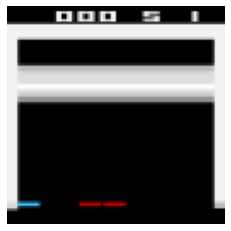

In [13]:
env.seed(32)

env.reset()
for _ in range(4): #Test control and get the trajectory
    time_step = env.step(3)

draw_obs(time_step.observation)
# save_fig('processed_invadar_game_pic')
plt.show()

In [14]:
from tf_agents.environments import TFPyEnvironment
import keras
import tensorflow as tf
from tf_agents.networks.q_network import QNetwork

tf_env = TFPyEnvironment(env)

preprocessing_layer = keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.) #Default layer design from book
fc_layer_params = [512]
conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)


In [15]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_steps = tf.Variable(0)
update_period = 4
optimizer = tf.keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0)
epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.1,
    decay_steps=250000 // update_period,
    end_learning_rate=0.01)
agent = DqnAgent(
    time_step_spec=tf_env.time_step_spec(),
    action_spec=tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=2000,
    td_errors_loss_fn=keras.losses.Huber(reduction="none"),
    gamma=0.99,
    train_step_counter=train_steps,
    epsilon_greedy=lambda:epsilon_fn(train_steps)
)
agent.initialize()

In [16]:
agent

In [17]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.replay_buffers.py_hashed_replay_buffer import PyHashedReplayBuffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=500000
)

replay_buffer_observer = replay_buffer.add_batch

In [18]:
class ShowProgress():
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [19]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric()
]

In [20]:
from tf_agents.eval.metric_utils import log_metrics
import logging

logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [23]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period
)

In [24]:
collect_driver

In [25]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())

init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000
)
final_time_step, final_policy_state = init_driver.run()

20000/20000

In [19]:
trajectories, buffer_info = replay_buffer.get_next(sample_batch_size=2, num_steps=3)
print(trajectories)
print(buffer_info)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Trajectory(
{'action': <tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[5, 1, 0],
       [0, 4, 5]], dtype=int64)>,
 'discount': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]])>,
 'observation': <tf.Tensor: shape=(2, 3, 84, 84, 4), dtype=uint8, numpy=
array([[[[[ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          ...,
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0]],

         [[ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          ...,
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0]],

         [[ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          ...,
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0]],

         ...,

         [[

In [20]:
print(trajectories._fields)

('step_type', 'observation', 'action', 'policy_info', 'next_step_type', 'reward', 'discount')


In [21]:
print('Shape of \'observation\': ', trajectories.observation.shape)
print('Shape of \'rewards\': ', trajectories.reward.shape)
print(trajectories.step_type.numpy())

Shape of 'observation':  (2, 3, 84, 84, 4)
Shape of 'rewards':  (2, 3)
[[1 1 1]
 [1 1 1]]


NameError: name 'trajectories' is not defined

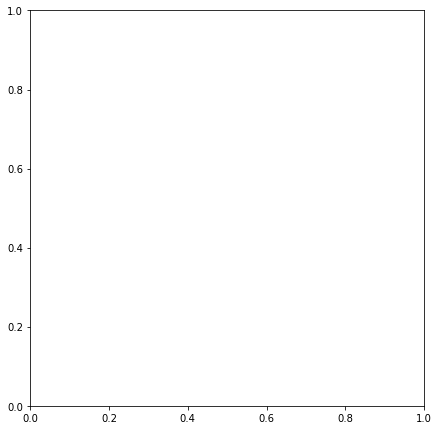

In [21]:
plt.figure(figsize=(24, 16))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row*3 + col+1)
        draw_obs(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig('sub_episode_plot_breakout')
plt.show()

簡單印出其中兩個 Trajectories

In [23]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=2)

In [24]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)


In [27]:
from tf_agents.policies.policy_saver import PolicySaver

saver = PolicySaver(agent.collect_policy, batch_size=None)

returns = []

def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(iteration, train_loss.loss.numpy()), end="")
        if (iteration % 1000 == 0):
            returns.append(train_metrics[2])
            log_metrics(train_metrics)

In [28]:
iterations = 50000
train_agent(iterations)

c:\Users\clare\anaconda3\envs\late-tf-env\lib\site-packages\gym\utils\seeding.py:47: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(


49999 loss:2.70412

In [29]:
iteration = range(0, iterations + 1, 1000)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

In [30]:
from matplotlib import animation

frames = []

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()


c:\Users\clare\anaconda3\envs\late-tf-env\lib\site-packages\gym\utils\seeding.py:47: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(


1000/1000

In [32]:
import PIL
import os

frame_images = [PIL.Image.fromarray(frame) for frame in frames[:1000]]
image_path = os.path.join("pictures", "invader.gif")
frame_images[0].save(image_path,format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=60,
                     loop=0)

In [ ]:
from tf_agents.utils import common

global_step = tf.compat.v1.train.get_global_step()
tempdir = 'D:/Workspace/Python/Self-Invader-agent'
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
)

In [ ]:
from tf_agents.policies import policy_saver
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

In [ ]:
print('Training one iteration....')
train_agent(1)

c:\Users\clare\anaconda3\envs\late-tf-env\lib\site-packages\gym\utils\seeding.py:47: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(


Training one iteration....
0 loss:4.64615

AssertionError: Tried to export a function which references 'untracked' resource Tensor("1882461:0", shape=(), dtype=resource). TensorFlow objects (e.g. tf.Variable) captured by functions must be 'tracked' by assigning them to an attribute of a tracked object or assigned to an attribute of the main object directly.

 Trackable Python objects referring to this tensor (from gc.get_referrers, limited to two hops):
<tf.Variable 'Variable:0' shape=() dtype=int32>